In [1]:
import sys
sys.path.append('python/')        # Define path

import time
startTime = time.time()           # Calculate time for running this notebook

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import ipywidgets as w
from matplotlib.widgets import RadioButtons
import load_galaxies as lg        # Load load_galaxies.py library

_Python help: Running the notebook the first time, make sure to run all cells to be able to make changes in the notebook. Hit Shift+Enter to run the cell or click on the top menu: Kernel > Restart & Run All > Restart and Run All Cells to rerun the whole notebook. If you make any changes in a cell, rerun that cell._

# Rotation Curve Plotting

The three steps of the rotation curve building process is plotting the measured velocity data, constructing the rotation curves for each component, and fitting the total velocity to the measured values. The following notebook explores the second step of the process by letting you select a galaxy out of four to build a rotation curve. The rotation of the bulge, disk and gas are imported from a prepared library (the calculation for their velocities is beyond the scope of this workshop). You can then calculate the rotation curve for the dark matter using an isometric density profile and its two free parameters, central core density ($\rho_0$) and radius ($r_c$). As a final exercise for this activity, plot the rotation curve with its total velocities and all its components and vary the free parameters to experiment with the curve.

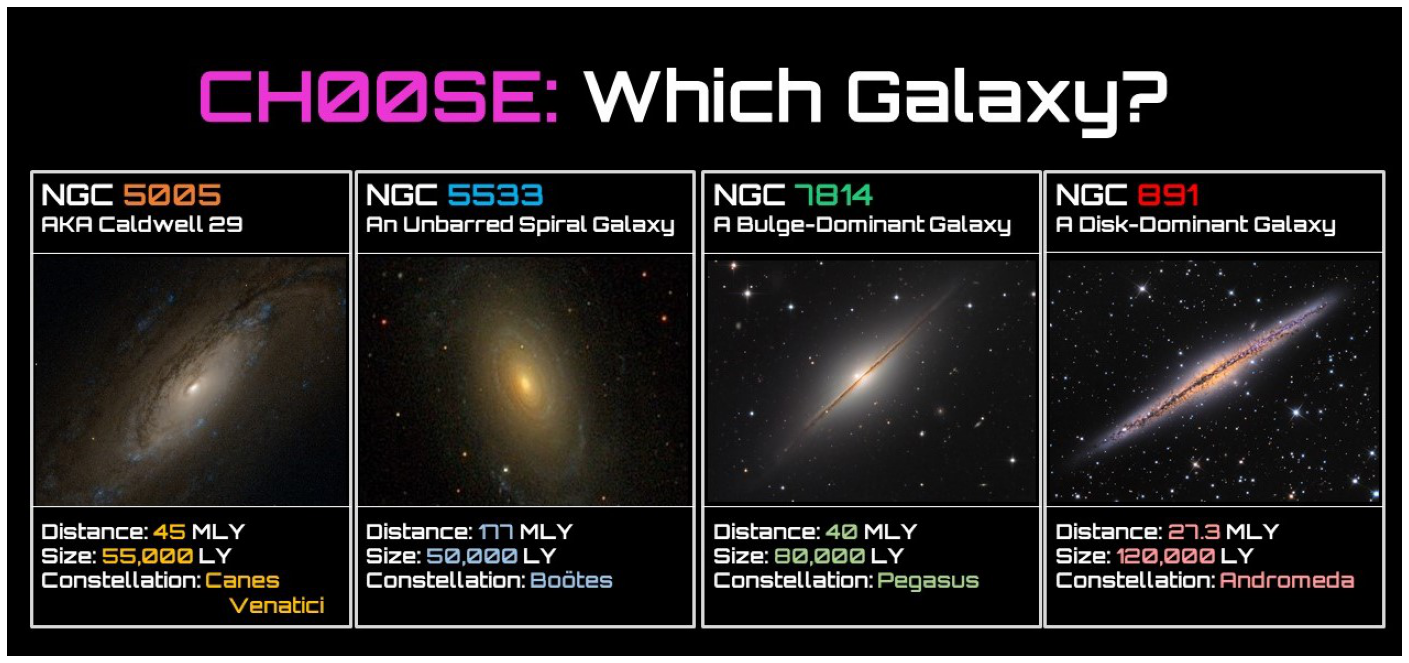

In [2]:
# Display image for choosing a galaxy
img = mpimg.imread('images/chooseWhichGalaxy.jpg')
plt.figure(figsize=(25,20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

1. __Choose your galaxy:__
Enter galaxy=lg.GALAXYNAME below to select your galaxy.

In [3]:
galaxy = lg.NGC0891                  # Options: lg.NGC5005 , lg.NGC5533 , lg.NGC7814 , lg.NGC0891

## Import measured radial velocity data of the chosen galaxy

In [4]:
# Measured data
measured_data = galaxy['measured_data']

# Separate the columns of the data into arrays
m_radii = galaxy['m_radii']           # Radius
m_velocities = galaxy['m_velocities'] # Velocity
m_r_errors = galaxy['m_r_errors']     # Errors in radius
m_v_errors = galaxy['m_v_errors']     # Errors in velocity         

## Import the Light Matter Components

The structure of a galaxy can be separated into individual components to simplify the process of producing a galactic rotation curve. <br>

The bulge and disk make up the two stellar components of spiral galaxies. The less dense disk is made from the spiral arms and the bulge makes up the dense spherical core of the galaxy. The mass of these components is estimated by using the mass-to-light ratio is used with photometric data of the luminosities. The variation in the stellar luminosity-to-mass ratio means there is a wider range of masses that are plausible for the stellar components.

The gas is distributed somewhat evenly throughout the galaxy's disk and is composed of mainly Hydrogen. The gas's composition is determined by using light emissions spectra to identify the elements present. The element’s known molecular mass is used to calculate the gas components mass with higher accuracy. For this reason, rotation curves are often plotted with the gas parameters fixed.

In [5]:
# Note: the following data has been 'splined' using scipy.interpolate.BSpline 
# which means the data points has been connected and turned into a function.
# You will need to call these variables as functions of radius at selected points. 
# For example: bulge_v(r), disk_v(r),...

# Bulge
bulge_v = galaxy['bulge']['spline']   
# Disk
disk_v = galaxy['disk']['spline']
# Gas
gas_v = galaxy['gas']['spline']

## Calculate central supermassive black hole component (NGC 5533 only)

**Note: this section only works for NGC 5533.** <br>
Calculate the central black hole component for galaxy NGC 5533. The other galaxies have their black hole component included with their bulge, which scientific publications may do depending on the focus of their research. For example: In a two-component model, only the halo and disk are plotted (see References: Casertano, 1983). In the case of NGC 7814, the bulge curve that is used in these calculations includes the possible black hole. (Note that this is not specified in the article (see References: Fraternali, Sancisi, and Kamphuis 2011) but is suggested in the NASA website: https://www.nasa.gov/feature/goddard/caldwell-43.) <br>

Since the extreme mass and negligible radius, a central supermassive black hole is represented as a point value and the rotation curve can be calculated using the orbital velocity of a point-mass. 
\begin{equation}
v_{BH} = \sqrt\frac{GM_{BH}}{r}
\end{equation}
<br>
>where:<br>
        $G$ = gravitational constant<br>
        $M_{BH}$ = mass of central supermassive black hole<br>
        $r$ = radius or distance from the center of the galaxy
    <br>

_Activity:_

1. Change the values for the radius while keeping the mass of the black hole fixed to see how it affects the velocity of the stars and gas. Use an estimate for the black hole’s mass.
2. Based on the values measured, how might the black hole component be affecting the galaxy's rotational velocity?
3. Change the mass of the black hole at a fixed radius to see how it affects the velocity of stars and gas. <br>

_Python help:_ 
- _If you would like to change a value but keep the original for future use, copy the line and then comment it out (i.e. type a # sign in front of the line) or just type a # sign in front of 'galaxy\['massbh'\]'. The mass of the black hole that is used in the calculation is printed below the cell._
- _Change the value of the mass of the black hole by changing the value for massbh. For example: massbh = 3e10_

In [6]:
# Set Parameters
massbh = galaxy['massbh']           # Mass of the central black hole in (solar mass) imported from a Python library
radius = 10                         # Radius to calculate velocity due to black hole component (in kpc)
G = 4.300e-6                        # Gravitational constant (kpc/solar mass*(km/s)^2)

# Display the mass of the black hole
print("Mass of the central supermassive black hole at the center of the galaxy {}: {:.3e} solar masses".format(galaxy['galaxyname'],massbh))

# Equation for point-mass rotation curve
def blackhole_v(r,massbh):
    return np.sqrt((G*massbh)/r)

# Displaying the value of the velocity of stars and gas at a chosen radius
print("Velocity at r=10[kpc]: {:.3f} km/s".format(blackhole_v(radius,massbh)))

Mass of the central supermassive black hole at the center of the galaxy NGC 891: 0.000e+00 solar masses
Velocity at r=10[kpc]: 0.000 km/s


## Calculate dark matter halo component

The Isothermal Density Profile is used to model the structure of the dark matter halo and takes the two parameters, central core radius ($r_c$) and central core density ($\rho_0$). The density profile is used to find the enclosed mass, which is then used to determine the rotational velocity defined by the parameters $\rho_0$ and $r_c$ and evaluated for the best fit. Other possible density profiles include Einasto profile or the Navarro-Frenk-White (NFW) profile (see References: Jimenez et al.) <br>

1. Consider the Isothermal Density Profile at large and small radii. How does the density change as we look further from the center? <br>

>__Isothermal Density Profile__: <br>
    \begin{equation}
    \rho(r) = \rho_{0}\left[1+{\left(\frac{r}{r_c}\right)}^{2}\right]^{-1}
    \end{equation}
    <br>
>>where:<br>
    $\rho_{0}$ = core density<br>
    $r_c$ = core radius<br>
    $r$ = radius 
    
>__Enclosed Mass__: <br>
    \begin{equation}
    M_{DM}(r) = \int_{0}^{r} 4\pi\rho(r^{\prime})r^{\prime 2}d r^{\prime}
    \end{equation}<br>
>>where:<br>
        $M_{DM}$ = mass of the dark matter halo<br>
        $\rho(r)$ = density profile
    <br>
    
>__Velocity__: <br>
    \begin{equation}
    v_{DM}^{2}(r) = \frac{GM_{DM}(r)}{r}
    \end{equation}<br>
    \begin{equation}
    v_{DM}(r) = \sqrt{4 \pi G \rho_{0} r_c^2 \big( 1- \frac{r_c}{r} \arctan{\frac{r}{r_c}}\big)}
    \end{equation}<br>
    
   >where:<br>
        $G$ = gravitational constant<br>
    <br>
    
2. Change the two dark matter parameters $\rho_0$ and $r_c$ in the next cell to see how the velocity of the dark matter changes at the selected radius.

In [7]:
# Set parameters
rho0 = galaxy['rho0']   # central mass density (in solar mass/kpc^3)
rc = galaxy['rc']       # core radius (in kpc)
radius = 10             # radius (in kpc)

# Display the two dark matter parameters
print("Central mass density: {:.2e} solar mass/kpc^3".format(rho0))
print("Core radius: {:.2f} kpc".format(rc))

# Equation for dark matter halo velocity
def halo_v(r,rho0,rc):
    v = np.sqrt(4*np.pi*G*rho0*rc**2*(1 - rc/r * np.arctan(r/rc)))
    return v

# Display the velocity at the selected radius
print("Velocity at {} kpc: {:.3f} km/s".format(radius,halo_v(radius,rho0,rc)))

Central mass density: 3.31e+07 solar mass/kpc^3
Core radius: 1.90 kpc
Velocity at 10 kpc: 68.993 km/s


## Calculate total velocity

All components of the galaxy contribute to the rotation curve or the total velocity of stars and gas. This can be added quadratically in the following way:

>__Total velocity__: <br>
    \begin{equation}
    v_{total}(r) = \sqrt{v_{bulge}^2 + v_{disk}^2 + v_{gas}^2 + v_{blackhole}^2 + v_{dm\ halo}^2}
    \end{equation}<br>

1. Modify the total rotational velocity WITH the dark matter component included by commenting out each galaxy component included in the _total_v_ function to see how it affects the rotation curve plotted in the next section. For example: remove the bulge by inserting a pound sign # before the term: _bulge_v(r)**2_.<br>

_Python help: Rerun the notebook to see the changes in the graph by hitting Shift+Enter on both the cells or by clicking on the menu: Kernel > Restart & Run All > Restart and Run All Cells._

In [8]:
# Total velocity WITH dark matter halo component
def total_v(r,massbh,rho0,rc):
    v = np.sqrt( bulge_v(r)**2                # bulge component
               + disk_v(r)**2                 # disk component
               + gas_v(r)**2                  # gas component
               + blackhole_v(r,massbh)**2     # central black hole component (this might be zero for NGC 891, NGC 7814 and NGC 5005 but it is because it's included in the bulge velocity)
               + halo_v(r,rho0,rc)**2)        # dark matter halo component
    return v

2. Modify the total rotational velocity WITHOUT the dark matter component included by changing the scaling parameters of each galaxy component. For example: if you want the contribution from the disk to the rotation curve to be doubled, change _dpref = 1_ to _dpref = 2_.

The scaling parameter is analogous to the mass-to-light ratio (M/L) that indicates how much mass it is expected from the light source. Because the mass is a rough estimation, the mass-to-light ratio is a good free parameter to use for curve fitting (see _8\_Interactive\_Fitting.ipynb_ activity). 

In [9]:
# Scaling parameters
bpref = 1      # Bulge 
dpref = 1      # Disk
gpref = 1      # Gas
bhpref = 1     # Central supermassive black hole

In [10]:
# Total velocity WITHOUT dark matter halo component
def total_v_noDM(r,massbh):
    v = np.sqrt( (bpref * bulge_v(r))**2      # bulge component + scaling parameter
               + (dpref * disk_v(r))**2       # disk component + scaling parameter
               + (gpref * gas_v(r))**2        # gas component + scaling parameter
               + (bhpref * blackhole_v(r,massbh))**2)      # central supermassive black hole component + scaling factor
    return v

## Plot all components and total velocity

Notice the difference between the total velocity with the dark matter halo component (red) and without the dark matter halo component (yellow). 

3. Are you able to scale the parts of the total velocity without dark matter to match the curve of the measured data? Do these scaling parameters make sense or are they unreasonable? <br>

_Sneak peak: In the activity _8\_Interactive\_Fitting.ipynb_, you won't have to guess these scaling parameters. Instead, you will be able to "fit" all curves to the measured data points and see what these multipliers might be._

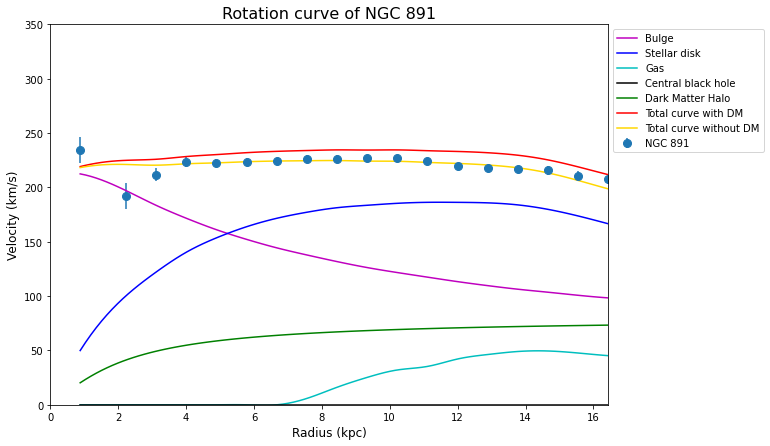

In [11]:
# Define radius for plotting
r_lowerlim = np.min(m_radii)                       # limit the radius to the min value of the measured radius
if r_lowerlim == 0:                                # getting rid of dividing by zero error
    r_lowerlim = 0.01
r_upperlim = np.max(m_radii)                       # limit the radius to the max value of the measured radius
r = np.linspace(r_lowerlim,r_upperlim,100)         # starting from zero results in a divide by zero error

# Plot 
plt.figure(figsize=(10.0,7.0))                     # size of the plot
plt.plot(r, bulge_v(r),            color='m', label='Bulge')
plt.plot(r, disk_v(r),             color='b', label='Stellar disk')                        
plt.plot(r, gas_v(r),              color='c', label='Gas')            
plt.plot(r, blackhole_v(r,massbh), color='k', label='Central black hole')    # only for NGC 5533         
plt.plot(r, halo_v(r,rho0,rc),     color='g', label='Dark Matter Halo')   

plt.plot(r, total_v(r,massbh,rho0,rc), color='r',    label='Total curve with DM')
plt.plot(r, total_v_noDM(r,massbh),    color='gold', label='Total curve without DM')

plt.errorbar(m_radii, m_velocities, yerr=m_v_errors, 
             marker='o', markersize=8,
             linestyle='none', 
             label='{}'.format(galaxy['galaxyname']))

plt.title('Rotation curve of {}'.format(galaxy['galaxyname']), fontsize=16)     # giving the plot a title
plt.xlabel('Radius (kpc)', fontsize=12)                           # labeling the x-axis
plt.ylabel('Velocity (km/s)', fontsize=12)                        # labeling the y-axis
plt.xlim(0,r_upperlim)                                            # limits of the x-axis
plt.ylim(0,350)                                                   # limits of the y-axis
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [12]:
# Time
executionTime = (time.time() - startTime)
ttt=executionTime/60
print(f'Execution time: {ttt:.2f} minutes')

Execution time: 0.04 minutes


# References
>Casertano, Stefano. __"Rotation curve of the edge-on spiral galaxy NGC 5907: disc and halo masses."__ _Monthly Notices of the Royal Astronomical Society_ 203, no. 3 (1983): 735-747. https://doi.org/10.1093/mnras/203.3.735. <br><br>
>Fraternali, F., R. Sancisi, and P. Kamphuis. __“A Tale of Two Galaxies: Light and Mass in NGC 891 and NGC 7814.”__ Astronomy &amp; Astrophysics 531 (June 13, 2011). https://doi.org/10.1051/0004-6361/201116634.<br><br> 
>Jimenez, Raul, Licia Verde, and S. Peng Oh. __"Dark halo properties from rotation curves."__ _Monthly Notices of the Royal Astronomical Society_ 339, no. 1 (2003): 243-259. https://doi.org/10.1046/j.1365-8711.2003.06165.x. <br><br>
>Kapteyn Institute. (n.d.). Groningen Image Processing System. __GIPSY, the GRONINGEN image processing system.__ https://www.astro.rug.nl/~gipsy/index.html. <br><br>
>Karukes, E. V., P. Salucci, and Gianfranco Gentile. __"The dark matter distribution in the spiral NGC 3198 out to 0.22 $R_{vir}$."__ _Astronomy & Astrophysics_ 578 (2015): A13. https://doi.org/10.1051/0004-6361/201425339. <br><br>
>Noordermeer, Edo. __"The rotation curves of flattened Sérsic bulges."__ _Monthly Notices of the Royal Astronomical Society_ 385, no. 3 (2007): 1359-1364. https://doi.org/10.1111/j.1365-2966.2008.12837.x. <br><br>
>Richards, Emily E., L. van Zee, K. L. Barnes, S. Staudaher, D. A. Dale, T. T. Braun, D. C. Wavle, et al. __“Baryonic Distributions in the Dark Matter Halo of NGC 5005.”__ Monthly Notices of the Royal Astronomical Society 449, no. 4 (June 1, 2015): 3981–96. https://doi.org/10.1093/mnras/stv568. 
***